# Import packages

In [164]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import time
from utils import A_cluster
from tqdm.auto import tqdm
from torchvision import transforms, datasets
from copy import deepcopy

# Configuration

In [284]:
class config:
    input = 28*28
    output = 10
    hid = 128    # RC Neurons
    thr = 0.5
    decay = 0.5
    rst = 0.05
    
    N_hid = hid
    p_in = 0.2        # ratio of inhibitory neurons
    gamma = 1.0       # shape factor of gamma distribution
    binary = True    # binary matrix of reservoir A
    net_type = 'BAC'  # type of reservoir connection topology
                      # 'ER',  # Erdos-Renyi Random Network
                      # 'ERC', # Clusters of Erdos-Renyi Networks
                      # 'BA',  # Barabasi-Albert Network
                      # 'BAC', # Clusters of Barabasi-Albert networks
                      # 'WS',  # Watts Strogatz small world networks
                      # 'WSC', # Clusters of Watts Strogatz small world networks
                      # 'RAN', # random network
                      # 'DTW', # Developmental Time Window for multi-cluster small-world network
    noise = True      # add noise in A
    noise_str = 0.05  # noise strength
    p_ER = 0.2        # connection probability when creating edges, for ER and WS graphs
    m_BA = 3          # number of edges to attach from a new node to existing nodes
    k = 5             # number of clusters in A
    R = 0.2           # distance factor when deciding connections in random network
    scale = False     # rescale matrix A with spectral radius
    
    
    num_minibatch = 10000
    num_per_label_minibatch = 20 # number of samples of each label in one mini-batch
    batch = 128
    epoch = 1000
    lr = 0.01
    l1 = 0.00015
    l1_targ = 600
    device = torch.device('cuda')
    

# Load datasets

In [285]:
from spikingjelly.datasets.shd import SpikingHeidelbergDigits
from spikingjelly.datasets.n_mnist import NMNIST

nmnist_train = NMNIST('D:\Ph.D\Research\SNN-SRT数据/N-MNIST', train=True, data_type='frame', frames_number=20, split_by='number')
nmnist_test = NMNIST('D:\Ph.D\Research\SNN-SRT数据/N-MNIST', train=False, data_type='frame', frames_number=20, split_by='number')
train_loader = torch.utils.data.DataLoader(dataset=nmnist_train, batch_size=config.batch, shuffle=True, drop_last=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(dataset=nmnist_test, batch_size=config.batch, shuffle=False, drop_last=False, num_workers=0)

SHD_train = SpikingHeidelbergDigits('D:\Ph.D\Research\SNN-SRT数据\SHD', train=True, data_type='frame', frames_number=20, split_by='number')
SHD_test = SpikingHeidelbergDigits('D:\Ph.D\Research\SNN-SRT数据\SHD', train=False, data_type='frame', frames_number=20, split_by='number')
train_loader = torch.utils.data.DataLoader(dataset=SHD_train, batch_size=config.batch, shuffle=True, drop_last=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(dataset=SHD_test, batch_size=config.batch, shuffle=False, drop_last=False, num_workers=0)


transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data/', train=False, transform=transform, download=True)
# train_dataset = datasets.CIFAR10(root='./data', train=True, download=True)
# test_dataset = datasets.CIFAR10(root='./data', train=False, download=True)
# train_dataset = datasets.CIFAR100(root='./data', train=True, download=True)
# test_dataset = datasets.CIFAR100(root='./data', train=False, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=config.batch, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=config.batch, shuffle=False)

The directory [D:\Ph.D\Research\SNN-SRT数据/N-MNIST\frames_number_20_split_by_number] already exists.
The directory [D:\Ph.D\Research\SNN-SRT数据/N-MNIST\frames_number_20_split_by_number] already exists.
The directory [D:\Ph.D\Research\SNN-SRT数据\SHD\extract] for saving extracted files already exists.
SpikingJelly will not check the data integrity of extracted files.
If extracted files are not integrated, please delete [D:\Ph.D\Research\SNN-SRT数据\SHD\extract] manually, then SpikingJelly will re-extract files from [D:\Ph.D\Research\SNN-SRT数据\SHD\download].
The directory [D:\Ph.D\Research\SNN-SRT数据\SHD\frames_number_20_split_by_number] already exists.
The directory [D:\Ph.D\Research\SNN-SRT数据\SHD\extract] for saving extracted files already exists.
SpikingJelly will not check the data integrity of extracted files.
If extracted files are not integrated, please delete [D:\Ph.D\Research\SNN-SRT数据\SHD\extract] manually, then SpikingJelly will re-extract files from [D:\Ph.D\Research\SNN-SRT数据\SHD\d

# RC Model

In [286]:
class ActFun(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return input.gt(0).float()

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        temp = abs(input - 0) < 0.5 # lens
        return grad_input * temp.float()

act_fun = ActFun.apply

def mem_update(input, mem, spk, thr, decay, rst):
    mem = rst * spk + mem * decay * (1-spk) + input
    spike = act_fun(mem - thr)
    return mem, spike

In [287]:
class RC(nn.Module):
    def __init__(self) -> None:
        super(RC, self).__init__()
        input = config.input
        hid = config.hid
        out = config.output
        self.fc_in = nn.Linear(input, hid)
        self.conv_in = nn.Sequential(
                                    nn.Conv2d(1, 16, 3),
                                    nn.ReLU(),
                                    nn.AvgPool2d(2, 2),
                                    nn.Conv2d(16, 16, 3),
                                    nn.ReLU(),
                                    nn.AvgPool2d(2, 2),
                                    nn.Flatten(),
                                    self.fc_in,
                                    )
        self.fc_in.requires_grad_ = False
        self.conv_in.requires_grad_ = False
        
        # self.A = nn.Parameter(torch.tensor(A_cluster(config)), requires_grad=False) # adjacency matrix
        self.A1 = nn.Linear(config.hid, config.hid, bias=False) # random initialized adjacency matrix
        self.A2 = nn.Linear(config.hid, config.hid, bias=False)
        nn.init.uniform_(self.A1.weight, a=0, b=1)
        nn.init.uniform_(self.A2.weight, a=0, b=1)
        self.fc_out = nn.Linear(hid*2, out)
        
        self.thr = nn.Parameter(torch.rand(config.hid)*config.thr, requires_grad=False)
        self.decay = nn.Parameter(torch.rand(config.hid)*config.decay, requires_grad=False)
        self.rst = nn.Parameter(torch.rand(config.hid)*config.rst, requires_grad=False)
        
        for name, p in self.named_parameters():
            if 'conv' in name or 'fc_in' in name:
                p.requires_grad = False
        
    def forward(self, input, device='cuda'):
        batch = input.shape[0]
        time_step = 10
        input = input.view(batch, config.input)
        # if len(input.shape)>2:
        #     batch, time_step = input.shape[0:2]
        
        hid1_mem = torch.zeros(batch, time_step+1, config.hid).uniform_(0, 0.1).to(device)
        hid1_spk = torch.zeros(batch, time_step+1, config.hid).to(device)
        hid2_mem = torch.zeros(batch, time_step+1, config.hid).uniform_(0, 0.1).to(device)
        hid2_spk = torch.zeros(batch, time_step+1, config.hid).to(device)
        
        sum1_spk = torch.zeros(batch, config.hid).to(device)
        sum2_spk = torch.zeros(batch, config.hid).to(device)
        
        for t in range(time_step):
            x = input > torch.rand(input.size()).to(device)
            x = self.fc_in(x.float())
            # x = self.conv_in(x.float())
            # x = self.fc_in(input[:,t,:])
            # x = self.conv_in(input[:, t, :, :, :])
            
            # x = x @ self.A
            x = F.sigmoid(self.A1(x))
            
            hid1_mem_tmp, hid1_spk_tmp = mem_update(x, hid1_mem[:,t,:], hid1_spk[:,t,:], self.thr, self.decay, self.rst)
            hid1_mem[:,t+1,:] = hid1_mem_tmp
            hid1_spk[:,t+1,:] = hid1_spk_tmp
            sum1_spk += hid1_spk_tmp
            
            x = F.sigmoid(self.A2(hid1_spk_tmp))
            hid2_mem_tmp, hid2_spk_tmp = mem_update(x, hid2_mem[:,t,:], hid2_spk[:,t,:], self.thr, self.decay, self.rst)
            hid2_mem[:,t+1,:] = hid2_mem_tmp
            hid2_spk[:,t+1,:] = hid2_spk_tmp
            
            sum2_spk += hid2_spk_tmp
        sum1_spk /= time_step
        sum2_spk /= time_step
        out = self.fc_out(torch.cat((sum1_spk, sum2_spk), dim=1))
        A_norm = torch.norm(self.A1.weight, p=1) + torch.norm(self.A2.weight, p=1)
        return out, hid2_mem, hid2_spk, A_norm


# Training pipeline

In [290]:
def train(model, optimizer, criterion, num_epochs, train_loader, test_loader, device):
    train_accs, test_accs = [], []
    for epoch in range(num_epochs):
        now = time.time()
        correct, total = 0, 0
        for i, (samples, labels) in enumerate(train_loader): # tqdm
            # samples = samples.requires_grad_().to(device)
            labels = labels.long().to(device)
            optimizer.zero_grad()
            outputs, _, _, A_norm = model(samples.to(device), device)
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted.cpu() == labels.long().cpu()).sum()
            
            loss = criterion(outputs, labels) + config.l1*F.relu(A_norm-config.l1_targ) # , torch.max(A_norm-6000, 0) 规定一个区间，
            loss.backward()
            optimizer.step()
        tr_acc = 100. * correct.numpy() / total
        ts_acc = test(model, test_loader, device)
        train_accs.append(tr_acc)
        test_accs.append(ts_acc)
        res_str = 'epoch: ' + str(epoch) \
                    + ' Loss: ' + str(loss.item())      \
                    + '. Tr Acc: ' + str(tr_acc)        \
                    + '. Ts Acc: ' + str(ts_acc)        \
                    + '. Time:' + str(time.time()-now)  \
                    + '. A norm:' + str(A_norm.item())
        print(res_str)
    return train_accs, test_accs

def test(model, dataloader, device='cuda'):
    correct, total = 0, 0
    for images, labels in dataloader:
        outputs, _, _, _ = model(images.to(device), device=device)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels.long().cpu()).sum()
    accuracy = 100. * correct.numpy() / total
    return accuracy

In [291]:
def inference(data_set, model):
    img = torch.zeros(len(data_set), 28, 28)
    for i, (d,l) in enumerate(data_set):
        img[i] = d[0]
    
    labels = np.array([d[1] for d in data_set])
    idx_per_label = [np.where(labels==i)[0] for i in range(config.output)]
    # generate mini batch
    for i in range(config.num_minibatch):
        batch_idx, batch_labels = [], []
        for j in range(config.output):
            batch_idx.extend(np.random.choice(idx_per_label[j], config.num_per_label_minibatch).tolist())
            batch_labels.extend([j]*config.num_per_label_minibatch)
        batch_data = img[batch_idx]
        batch_labels = torch.tensor(batch_labels)
        
        # print(i, batch_data.shape, batch_labels)
        out, hid_mem, hid_spk = model(batch_data.to('cuda'))
        _, predicted = torch.max(out.data, 1)
        acc = (predicted.cpu() == batch_labels.long().cpu()).sum()/config.num_per_label_minibatch/config.output
        print(hid_mem.shape, hid_spk.shape, acc)

# inference(test_dataset, model)

In [292]:
model = RC().to(config.device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=config.lr)
acc = train(model, optimizer, criterion, config.epoch, train_loader, test_loader, 'cuda')
accuracy = test(model, test_loader)

epoch: 0 Loss: 0.5603919625282288. Tr Acc: 78.02. Ts Acc: 84.27. Time:33.647075176239014. A norm:1002.3130493164062
epoch: 1 Loss: 0.40313592553138733. Tr Acc: 86.03333333333333. Ts Acc: 88.04. Time:32.858025789260864. A norm:756.892333984375
epoch: 2 Loss: 0.5349957942962646. Tr Acc: 86.98. Ts Acc: 88.08. Time:32.81189799308777. A norm:672.2493896484375
epoch: 3 Loss: 0.48637524247169495. Tr Acc: 87.26833333333333. Ts Acc: 87.95. Time:32.61699295043945. A norm:633.9241333007812
epoch: 4 Loss: 0.36704128980636597. Tr Acc: 87.40333333333334. Ts Acc: 88.78. Time:32.85253310203552. A norm:659.9481201171875
epoch: 5 Loss: 0.4379185438156128. Tr Acc: 87.54166666666667. Ts Acc: 89.61. Time:32.66216564178467. A norm:640.6828002929688
epoch: 6 Loss: 0.3342975974082947. Tr Acc: 87.91333333333333. Ts Acc: 87.19. Time:32.73686599731445. A norm:655.2998657226562
epoch: 7 Loss: 0.6172505021095276. Tr Acc: 87.86. Ts Acc: 88.41. Time:34.02914071083069. A norm:680.5218505859375
epoch: 8 Loss: 0.421375

KeyboardInterrupt: 

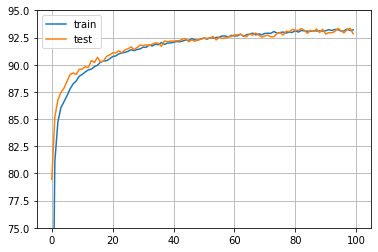

In [239]:
plt.plot(acc[0], label='train')
plt.plot(acc[1], label='test')
plt.grid()
plt.axis([-5, 105, 75, 95])
plt.legend()

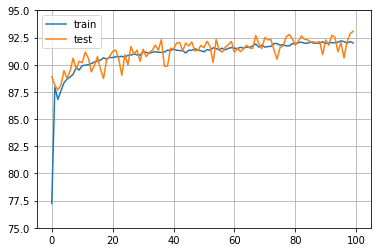

In [227]:
plt.plot(acc[0], label='train')
plt.plot(acc[1], label='test')
plt.grid()
plt.axis([-5, 105, 75, 95])
plt.legend()

# Test

In [240]:
with torch.no_grad():
    for i in range(10):
        np.random.seed(i)
        torch.manual_seed(i)
        torch.cuda.manual_seed_all(i)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
        print(test(model, test_loader))

93.08
93.26
93.3
92.91
93.12
93.01
93.04
93.23
93.13
93.08


In [242]:
np.mean([93.08,93.26,93.3,92.91,93.12,93.01,93.04,93.23,93.13,93.08])

93.116

# Pruning

In [278]:
# 1-(model.A.weight.abs()<8.5e-3).sum()/65536
(model.A2.weight.abs()<=2e-3).sum()/128/128

tensor(0.8840, device='cuda:0')

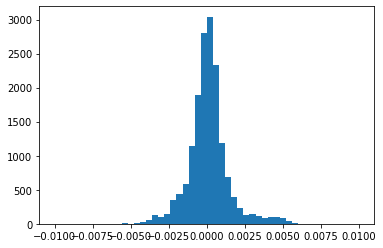

In [283]:
stat = plt.hist(model.A2.weight.flatten().detach().cpu().numpy(), bins=50, range=[-0.01, 0.01])

In [282]:
RC_model = deepcopy(model)
with torch.no_grad():
    baseline = 10e-3
    RC_model.A1.weight[RC_model.A1.weight.abs() <= baseline] = 0
    baseline = 2e-3
    RC_model.A2.weight[RC_model.A2.weight.abs() <= baseline] = 0
    # RC_model.A.weight[RC_model.A.weight.abs() > baseline] = 1.0
    print(((RC_model.A1.weight==0).sum() + (RC_model.A2.weight==0).sum()) / (2*config.hid**2))
    
    acc_mean = []
    for i in range(10):
        np.random.seed(i)
        torch.manual_seed(i)
        torch.cuda.manual_seed_all(i)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        acc_mean.append(test(RC_model, test_loader))
    print(np.mean(acc_mean), acc_mean)
    

tensor(0.8588, device='cuda:0')
93.12899999999999 [93.06, 93.35, 93.21, 92.88, 93.23, 93.03, 93.04, 93.24, 93.15, 93.1]


In [158]:
A = RC_model.A.weight.cpu().data.numpy()
x, y = np.where(A>baseline)
x_index = y_index = [0]*config.hid
for xx, yy in zip(x, y):
    x_index[xx] += 1
    y_index[yy] += 1
x_important = np.where(np.array(x_index)>40)[0]
y_important = np.where(np.array(y_index)>40)[0]
node_important = [0]*config.hid
for i in range(256):
    if x_index[i]>=40 and y_index[i]>=40:
        node_important[i] += 1
node_important = np.where(np.array(node_important)>=1)[0]

In [141]:
RC_model.thr += torch.rand(config.hid).to('cuda')*0.001
test(RC_model, test_loader)

90.27

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 256 (seed=266230, Thu Jun  8 12:11:51 2023)
0 -90.35
0 -90.22
0 -90.1
0 -90.03
0 -90.15
0 -90.25
0 -90.13
0 -90.04
0 -89.97
0 -90.19
1 -89.99
1 -89.99
1 -90.06
1 -90.13
1 -90.06
1 -90.18
1 -90.09
1 -90.19
1 -90.18
1 -90.05
2 -90.16
2 -90.25
2 -90.15
2 -90.14
2 -90.26
2 -90.0
2 -90.18
2 -90.15
2 -90.22
2 -90.12
3 -90.1
3 -90.22
3 -90.14
3 -90.17
3 -90.06
3 -90.11
3 -89.94
3 -90.1
3 -90.11
3 -90.24
4 -90.03
4 -90.17
4 -90.23
4 -90.1
4 -90.27
4 -90.1
4 -90.05
4 -90.0
4 -90.16
4 -90.09
5 -90.11
5 -90.14
5 -90.13
5 -89.93
5 -90.07
5 -90.13
5 -89.98
5 -90.1
5 -90.17
5 -90.14
6 -89.97
6 -90.2
6 -90.18
6 -90.2
6 -90.08
6 -89.9
6 -90.24
6 -90.27
6 -90.11
6 -89.99
7 -89.95
7 -90.1
7 -89.98
7 -90.2
7 -90.05
7 -90.19
7 -90.09
7 -90.02
7 -89.97
7 -90.07
8 -90.02
8 -90.15
8 -90.06
8 -90.15
8 -90.03
8 -90.07
8 -90.18
8 -90.02
8 -90.04
8 -90.14
9 -90.07
9 -90.12
9 -89.99
9 -90.18
9 -90.16
9 -90.03
9 -90.13
9 -90.2
9 -90.05
9 -90.15
10 -90.12
10 -90.13
1

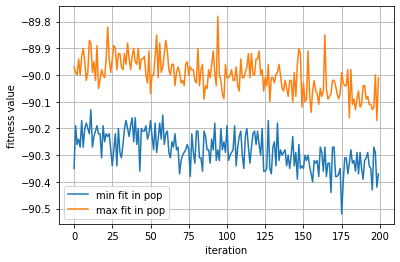

In [163]:
import cma

def fitness(x):
    tmp_model = deepcopy(RC_model)
    tmp_model.to('cpu')
    tmp_model.thr += torch.tensor(x)*0.01
    return -test(tmp_model, test_loader, device='cpu')

es = cma.CMAEvolutionStrategy(x0=[0.1]*256,
                                sigma0=0.1,
                                inopts={'popsize': 10}
                                )

log = []
for iteration in range(200):
    solutions = es.ask()
    fit = []
    for solution in solutions:
        fit_tmp = fitness(solution)
        fit.append(fit_tmp)
        print(iteration, fit_tmp)
        
    log.append([min(fit), max(fit)])
    es.tell(solutions, fit)

print('best solution\n', solutions[np.argmin(fit)])

log = np.array(log)
plt.plot(log[:,0])
plt.plot(log[:,1])
plt.grid()
plt.xlabel('iteration')
plt.ylabel('fitness value')
plt.legend(['min fit in pop', 'max fit in pop'])
plt.show()

In [17]:
model = RC()
non_zero, per_node = [], []
for i in range(config.hid):
    model.A[i,:] = 0
    model.A[:,i] = 0
    # print(i, (model.A!=0).sum(), (model.A!=0).sum()/256)
    non_zero.append((model.A!=0).sum().item())
    per_node.append((model.A!=0).sum().item()/config.hid)

In [213]:
from thop import profile

model_tmp = RC().to('cuda')
params = sum(param.numel() for param in model_tmp.parameters() if param.requires_grad)
print("Parameters: {:.6f}M".format(params / 1e6))

# input = torch.randn(1, 20, 2, 34, 34).cuda() #.to(config.device)
# flops, params = profile(model_tmp.cuda(), inputs=(input,))
# print("FLOPS: {:.2f}M".format(flops / 1e6))
# print("Parameters: {:.2f}K".format(params / 1e3))

Parameters: 2.117642M


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

thresh = 0.15
lens = 0.5
probs = 0.5
decay = 0.6

cfg_cnn = [(2, 64, 3, 1, 3),
           (64, 128, 2, 1, 3),
           (128, 256, 2, 1, 3),
            (256, 256, 1, 1, 3),
           ]
cfg_fc = [512, 512, 200]

def mem_update(opts, x, mem, spike):
    mem = mem * decay * (1 - spike) + opts(x)
    spike = act_fun(mem - thresh)
    return mem, spike

class ActFun(torch.autograd.Function):

    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return input.gt(0).float()

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        temp = abs(input)<lens
        return grad_input * temp.float()
act_fun = ActFun.apply


def mem_update(opts, x, mem, spike):
    mem = mem * decay * (1 - spike) + opts(x)
    spike = act_fun(mem - thresh)
    return mem, spike

class SNN(nn.Module):
    def __init__(self, **kwargs):
        super(SNN, self).__init__()
        self.device = kwargs.get('device')

        in_planes, out_planes, stride, padding, kernel_size = cfg_cnn[0]
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding)

        in_planes, out_planes, stride, padding, kernel_size = cfg_cnn[1]
        self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn2 = nn.BatchNorm2d(in_planes)

        in_planes, out_planes, stride, padding, kernel_size = cfg_cnn[2]
        self.conv3 = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn3 = nn.BatchNorm2d(in_planes)

        in_planes, out_planes, stride, padding, kernel_size = cfg_cnn[3]
        self.conv4 = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn4 = nn.BatchNorm2d(in_planes)

        inp_dim = 5 * 7 * out_planes
        self.fc1 = nn.Linear(inp_dim, cfg_fc[0])
        self.fc2 = nn.Linear(cfg_fc[0], cfg_fc[1])

    def forward(self, dvs_inp, out_mode = 'rate'):
        batch_size, seq_len, channel, w, h = dvs_inp.size()
        dvs_inp = dvs_inp.permute([1,0,2,3,4])
        c1_mem = c1_spike = torch.zeros(batch_size, cfg_cnn[0][1], 44, 58, device=self.device)
        c2_mem = c2_spike = torch.zeros(batch_size, cfg_cnn[1][1], 22, 29, device=self.device)
        c3_mem = c3_spike = torch.zeros(batch_size, cfg_cnn[2][1], 11, 15, device=self.device)
        c4_mem = c4_spike = torch.zeros(batch_size, cfg_cnn[3][1], 11, 15, device=self.device)

        h1_sum = h1_mem = h1_spike = torch.zeros(batch_size, cfg_fc[0], device=self.device)
        h2_sum = h2_mem = h2_spike = torch.zeros(batch_size, cfg_fc[1], device=self.device)
        out_spike = torch.zeros(seq_len, batch_size, cfg_fc[1], device=self.device)
        for step in range(seq_len):
            spike_inp = dvs_inp[step]
            c1_mem, c1_spike = mem_update(self.conv1, spike_inp.float(), c1_mem, c1_spike)
            c2_mem, c2_spike = mem_update(self.conv2, self.bn2(c1_spike), c2_mem, c2_spike)
            c3_mem, c3_spike = mem_update(self.conv3, self.bn3(c2_spike), c3_mem, c3_spike)
            # c4_mem, c4_spike = mem_update(self.conv4, c3_spike, c4_mem, c4_spike)
            c4_mem, c4_spike = mem_update(self.conv4, self.bn4(c3_spike), c4_mem, c4_spike)
            x = F.avg_pool2d(c4_spike, 2).view(batch_size, -1)

            h1_mem, h1_spike = mem_update(self.fc1, x, h1_mem, h1_spike)
            h2_mem, h2_spike = mem_update(self.fc2, h1_spike, h2_mem, h2_spike)
            h2_sum += h2_spike
            out_spike[step] = h2_spike
        out = h2_sum / seq_len
        if out_mode == 'time':
            out = out_spike
        else:
            out = h2_sum / seq_len
        return out


In [ ]:
import os
import torch
import torch.utils.model_zoo
import torchvision.models as models
from src.model.snn import *
from src.model.cann import CANN
from src.tools.utils import *

os.environ['CUDA_VISIBLE_DEVICES'] = "3"
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

class MHNN(nn.Module):
    def __init__(self, **kwargs):
        super(MHNN, self).__init__()

        self.cnn_arch = kwargs.get('cnn_arch')
        self.num_class = kwargs.get('num_class')
        self.cann_num = kwargs.get('cann_num')
        self.rnn_num = kwargs.get('rnn_num')
        self.lr = kwargs.get('lr')
        self.batch_size = kwargs.get('batch_size')
        self.sparse_lambdas = kwargs.get('sparse_lambdas')
        self.r = kwargs.get('r')

        self.reservoir_num = kwargs.get('reservoir_num')
        self.threshold = kwargs.get('spiking_threshold')

        self.num_epoch = kwargs.get('num_epoch')
        self.num_iter = kwargs.get('num_iter')
        self.w_fps = kwargs.get('w_fps')
        self.w_gps = kwargs.get('w_gps')
        self.w_dvs = kwargs.get('w_dvs')
        self.w_head = kwargs.get('w_head')
        self.w_time = kwargs.get('w_time')

        self.seq_len_aps = kwargs.get('seq_len_aps')
        self.seq_len_gps = kwargs.get('seq_len_gps')
        self.seq_len_dvs = kwargs.get('seq_len_dvs')
        self.seq_len_head = kwargs.get('seq_len_head')
        self.seq_len_time = kwargs.get('seq_len_time')
        self.dvs_expand = kwargs.get('dvs_expand')

        self.ann_pre_load = kwargs.get('ann_pre_load')
        self.snn_pre_load = kwargs.get('snn_pre_load')
        self.re_trained = kwargs.get('re_trained')

        self.train_exp_idx = kwargs.get('train_exp_idx')
        self.test_exp_idx = kwargs.get('test_exp_idx')

        self.data_path = kwargs.get('data_path')
        self.snn_path = kwargs.get('snn_path')

        #self.device = kwargs.get('device')
        self.device = device

        if self.ann_pre_load:
            print("=> Loading pre-trained model '{}'".format(self.cnn_arch))
            self.cnn = models.__dict__[self.cnn_arch](pretrained=self.ann_pre_load)
        else:
            print("=> Using randomly inizialized model '{}'".format(self.cnn_arch))
            self.cnn = models.__dict__[self.cnn_arch](pretrained=self.ann_pre_load)

        if self.cnn_arch == "mobilenet_v2":
            """ MobileNet """
            self.feature_dim = self.cnn.classifier[1].in_features
            self.cnn.classifier[1] = nn.Identity()

        elif self.cnn_arch == "resnet50":
            """ Resnet50 """

            self.feature_dim = 512

            # self.cnn.layer1 = nn.Identity()
            self.cnn.layer2 = nn.Identity()
            self.cnn.layer3 = nn.Identity()
            self.cnn.layer4 = nn.Identity()
            self.cnn.fc = nn.Identity()

            self.cnn.layer1[1] = nn.Identity()
            self.cnn.layer1[2] = nn.Identity()

            # self.cnn.layer2[0] = nn.Identity()
            # self.cnn.layer2[0].conv2 = nn.Identity()
            # self.cnn.layer2[0].bn2 = nn.Identity()

            fc_inputs = 256
            self.cnn.fc = nn.Linear(fc_inputs,self.feature_dim)

        else:
            print("=> Please check model name or configure architecture for feature extraction only, exiting...")
            exit()

        for param in self.cnn.parameters():
            param.requires_grad = self.re_trained

        #############
        # SNN module
        #############
        self.snn = SNN(device = self.device).to(self.device)
        self.snn_out_dim = self.snn.fc2.weight.size()[1]
        self.ann_out_dim = self.feature_dim
        self.cann_out_dim = 4 * self.cann_num
        self.reservior_inp_num = self.ann_out_dim + self.snn_out_dim + self.cann_out_dim
        self.LN = nn.LayerNorm(self.reservior_inp_num)
        if self.snn_pre_load:
            self.snn.load_state_dict(torch.load(self.snn_path)['snn'])

        #############
        # CANN module
        #############
        self.cann_num = self.cann_num
        self.cann = None
        self.num_class = self.num_class

        #############
        # MLSM module
        #############
        self.input_size = self.feature_dim
        self.reservoir_num = self.reservoir_num

        self.threshold = 0.5

        self.decay = nn.Parameter(torch.rand(self.reservoir_num))

        self.K = 128
        self.num_block = 5
        self.num_blockneuron = int(self.reservoir_num / self.num_block)

        self.decay_scale = 0.5
        self.beta_scale = 0.1

        self.thr_base1 = self.threshold

        self.thr_beta1 = nn.Parameter(self.beta_scale * torch.rand(self.reservoir_num))

        self.thr_decay1 = nn.Parameter(self.decay_scale * torch.rand(self.reservoir_num))

        self.ref_base1 = self.threshold
        self.ref_beta1 = nn.Parameter(self.beta_scale * torch.rand(self.reservoir_num))
        self.ref_decay1 = nn.Parameter(self.decay_scale * torch.rand(self.reservoir_num))

        self.cur_base1 = 0
        self.cur_beta1 = nn.Parameter(self.beta_scale * torch.rand(self.reservoir_num))
        self.cur_decay1 = nn.Parameter(self.decay_scale * torch.rand(self.reservoir_num))

        self.project = nn.Linear(self.reservior_inp_num, self.reservoir_num)

        self.project_mask_matrix = torch.zeros((self.reservior_inp_num, self.reservoir_num))


        input_node_list = [0, self.ann_out_dim, self.snn_out_dim, self.cann_num * 2, self.cann_num]

        input_cum_list = np.cumsum(input_node_list)

        for i in range(len(input_cum_list) - 1):
            self.project_mask_matrix[input_cum_list[i]:input_cum_list[i + 1],
            self.num_blockneuron * i:self.num_blockneuron * (i + 1)] = 1

        self.project.weight.data = self.project.weight.data * self.project_mask_matrix.t()

        self.lateral_conn = nn.Linear(self.reservoir_num, self.reservoir_num)

        self.lateral_conn_mask = torch.rand(self.reservoir_num, self.reservoir_num) > 0.8

        self.lateral_conn_mask = self.lateral_conn_mask * (1 - torch.eye(self.reservoir_num, self.reservoir_num))

        self.lateral_conn.weight.data = 0 * self.lateral_conn.weight.data * self.lateral_conn_mask.T

        #############
        # readout module
        #############

        # self.mlp1 = nn.Linear(self.reservoir_num, 256)
        # self.mlp2 = nn.Linear(256, self.num_class)
        self.mlp =  nn.Linear(self.reservoir_num, self.num_class)

    def cann_init(self, data):
        self.cann = CANN(data)

    def lr_initial_schedule(self, lrs=1e-3):
        hyper_param_list = ['decay',
                            'thr_beta1', 'thr_decay1',
                            'ref_beta1', 'ref_decay1',
                            'cur_beta1', 'cur_decay1']
        hyper_params = list(filter(lambda x: x[0] in hyper_param_list, self.named_parameters()))
        base_params = list(filter(lambda x: x[0] not in hyper_param_list, self.named_parameters()))
        hyper_params = [x[1] for x in hyper_params]
        base_params = [x[1] for x in base_params]
        optimizer = torch.optim.SGD(
            [
                {'params': base_params, 'lr': lrs},
                {'params': hyper_params, 'lr': lrs / 2},
            ], lr=lrs, momentum=0.9, weight_decay=1e-7
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, float(self.num_epoch))
        return optimizer, scheduler

    def wta_mem_update(self, fc, fv, k, inputx, spike, mem, thr, ref, last_cur):
        state = fc(inputx)
        mem = (mem - spike * ref) * self.decay + state + last_cur
        q0 = (100 -20)/100
        mem = mem.reshape(self.batch_size, self.num_blockneuron, -1)
        nps = torch.quantile(mem, q=q0, keepdim=True, axis=1)
        # nps =mem.max(axis=1,keepdim=True)[0] - thr

        mem = F.relu(mem - nps).reshape(self.batch_size, -1)

        spike = act_fun(mem - thr)
        return spike.float(), mem

    def trace_update(self, trace, spike, decay):
        return trace * decay + spike

    def forward(self, inp, epoch=100):
        aps_inp = inp[0].to(self.device)
        gps_inp = inp[1]
        dvs_inp = inp[2].to(self.device)
        head_inp = inp[3].to(self.device)

        batch_size, seq_len, channel, w, h = aps_inp.size()
        if self.w_fps > 0:
            aps_inp = aps_inp.view(batch_size * seq_len, channel, w, h)
            aps_out = self.cnn(aps_inp)
            out1 = aps_out.reshape(batch_size, self.seq_len_aps, -1).permute([1, 0, 2])
        else:
            out1 = torch.zeros(self.seq_len_aps, batch_size, -1, device=self.device).to(torch.float32)

        if self.w_dvs > 0:
            out2 = self.snn(dvs_inp, out_mode='time')
        else:
            out2 = torch.zeros(self.seq_len_dvs * 3, batch_size, self.snn_out_dim, device=self.device).to(torch.float32)

        ### CANN module
        if self.w_gps + self.w_head + self.w_time > 0:
            gps_record = []
            for idx in range(batch_size):
                buf = self.cann.update(torch.cat((gps_inp[idx],head_inp[idx].cpu()),axis=1), trajactory_mode=True)
                gps_record.append(buf[None, :, :, :])
            gps_out = torch.from_numpy(np.concatenate(gps_record)).cuda()
            gps_out = gps_out.permute([1, 0, 2, 3]).reshape(self.seq_len_gps, batch_size, -1)
        else:
            gps_out = torch.zeros((self.seq_len_gps, batch_size, self.cann_out_dim), device=self.device)

        # A generic CANN module was used for rapid testing; CANN1D/2D are provided in cann.py
        out3 = gps_out[:, :, self.cann_num:self.cann_num * 3].to(self.device).to(torch.float32)  # position
        out4 = gps_out[:, :, : self.cann_num].to(self.device).to(torch.float32)  # time
        out5 = gps_out[:, :, - self.cann_num:].to(self.device).to(torch.float32)  # direction

        out3 *= self.w_gps
        out4 *= self.w_time
        out5 *= self.w_head

        expand_len = int(self.seq_len_gps * self.seq_len_aps / np.gcd(self.seq_len_gps, self.seq_len_dvs) * self.dvs_expand)
        input_num = self.feature_dim + self.snn.fc2.weight.size()[1] + self.cann_num * self.dvs_expand

        r_spike = r_mem = r_sumspike = torch.zeros(batch_size, self.reservoir_num, device=self.device)

        thr_trace = torch.zeros(batch_size, self.reservoir_num, device=self.device)
        ref_trace = torch.zeros(batch_size, self.reservoir_num, device=self.device)
        cur_trace = torch.zeros(batch_size, self.reservoir_num, device=self.device)

        K_winner = self.K * (1 + np.clip(self.num_epoch - epoch, a_min=0, a_max=self.num_epoch) / self.num_epoch)

        out1_zeros = torch.zeros_like(out1[0], device=self.device)
        out3_zeros = torch.zeros_like(out3[0], device=self.device)
        out4_zeros = torch.zeros_like(out4[0], device=self.device)
        out5_zeros = torch.zeros_like(out5[0], device=self.device)

        self.project.weight.data = self.project.weight.data * self.project_mask_matrix.t().cuda()
        self.lateral_conn.weight.data = self.lateral_conn.weight.data * self.lateral_conn_mask.T.cuda()

        self.decay.data = torch.clamp(self.decay.data, min=0, max=1.)
        self.thr_decay1.data = torch.clamp(self.thr_decay1.data, min=0, max=1.)
        self.ref_decay1.data = torch.clamp(self.ref_decay1.data, min=0, max=1)
        self.cur_decay1.data = torch.clamp(self.cur_decay1.data, min=0, max=1)

        for step in range(expand_len):

            idx = step % 3
            if idx == 2:
                combined_input = torch.cat((out1[step // 3], out2[step], out3[step // 3], out4[step // 3], out5[step // 3]), axis=1)
            else:
                combined_input = torch.cat((out1_zeros, out2[step],out3_zeros, out4_zeros, out5_zeros), axis=1)

            thr = self.thr_base1 + thr_trace * self.thr_beta1
            # ref = self.ref_base1 + ref_trace * self.ref_beta1 # option: ref = self.ref_base1
            ref = self.ref_base1
            cur = self.cur_base1 + cur_trace * self.cur_beta1

            inputx = combined_input.float()
            r_spike, r_mem = self.wta_mem_update(self.project, 
                                                 self.lateral_conn, 
                                                 K_winner, 
                                                 inputx, 
                                                 r_spike, 
                                                 r_mem,
                                                 thr, 
                                                 ref, 
                                                 cur)
            thr_trace = self.trace_update(thr_trace, r_spike, self.thr_decay1)
            ref_trace = self.trace_update(ref_trace, r_spike, self.ref_decay1)
            cur_trace = self.trace_update(cur_trace, r_spike, self.cur_decay1)
            r_sumspike = r_sumspike + r_spike

        # cat_out = F.dropout(r_sumspike, p=0.5, training=self.training)
        # out1 = self.mlp1(r_sumspike).relu()
        # out2 = self.mlp2(out1)
        out2 = self.mlp(r_sumspike)

        neuron_pop = r_sumspike.reshape(batch_size, -1, self.num_blockneuron).permute([1, 0, 2])
        return out2, (neuron_pop[0], neuron_pop[1])
